In [5]:
# Initialisation
import numpy as np


from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram

ImportError: cannot import name 'execute' from 'qiskit' (/Users/lukepower/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/qiskit/__init__.py)

In [2]:
from sklearn.datasets import load_breast_cancer
breast_cancer_data = load_breast_cancer()

Breast Cancer Wisconsin (Diagnostic) Dataset Summary:
- 569 instances, 30 numeric predictive attributes plus class.
- Attributes include various measurements like radius, texture, perimeter, area, and more, computed as mean, standard error, and "worst."
- Two classes: Malignant (212 instances) and Benign (357 instances), showing an imbalanced distribution.
- Features describe cell nuclei characteristics from FNA breast mass images.
- Features span a wide range of values, indicating scaling may be necessary for machine learning.

In [4]:
features = breast_cancer_data.data
labels = breast_cancer_data.target

Normalize the features; transform all the features onto 0-1.

In [5]:
from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(features, columns=breast_cancer_data.feature_names)
df['class'] = [breast_cancer_data.target_names[label] for label in labels]

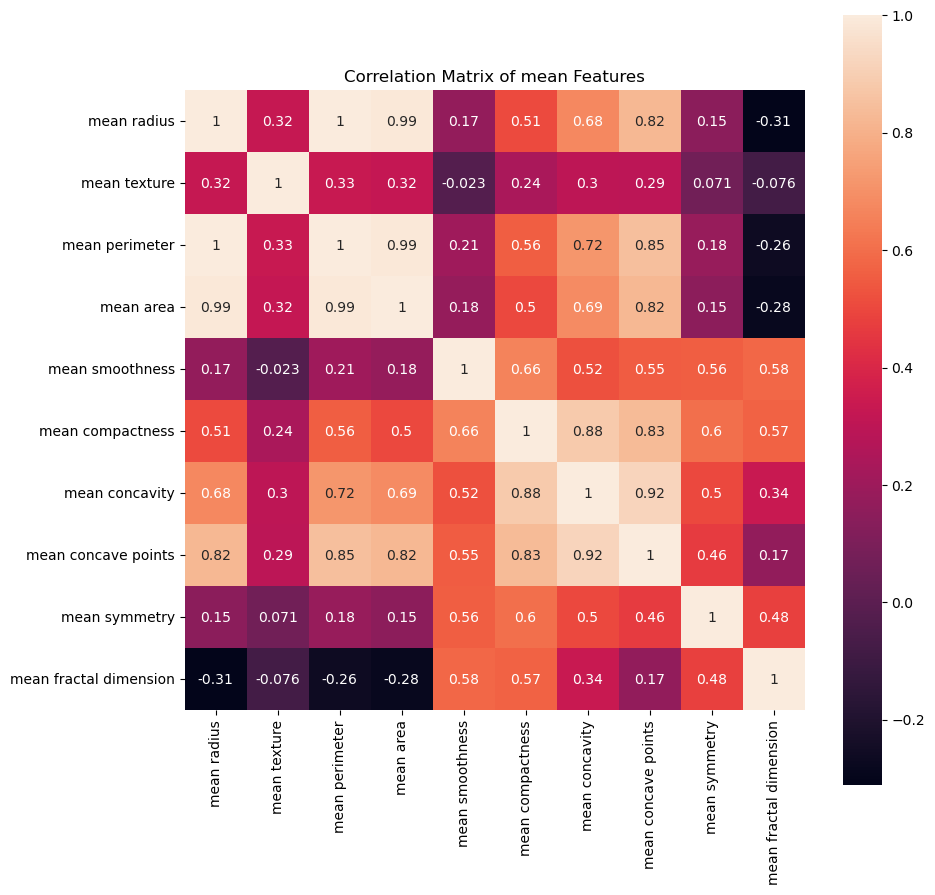

In [9]:
feature_names = breast_cancer_data.feature_names
feature_means = feature_names[:10]
plt.figure(figsize = (10,10))
heat = sns.heatmap(df[feature_means].corr(), vmax=1, square=True, annot=True)
plt.title('Correlation Matrix of mean Features')
plt.savefig('mean_features_corr.png')
plt.show()

There is some obvious covariance between some feature, particularly mean radius, mean perimeter, and mean area, which make sense being geometric values.

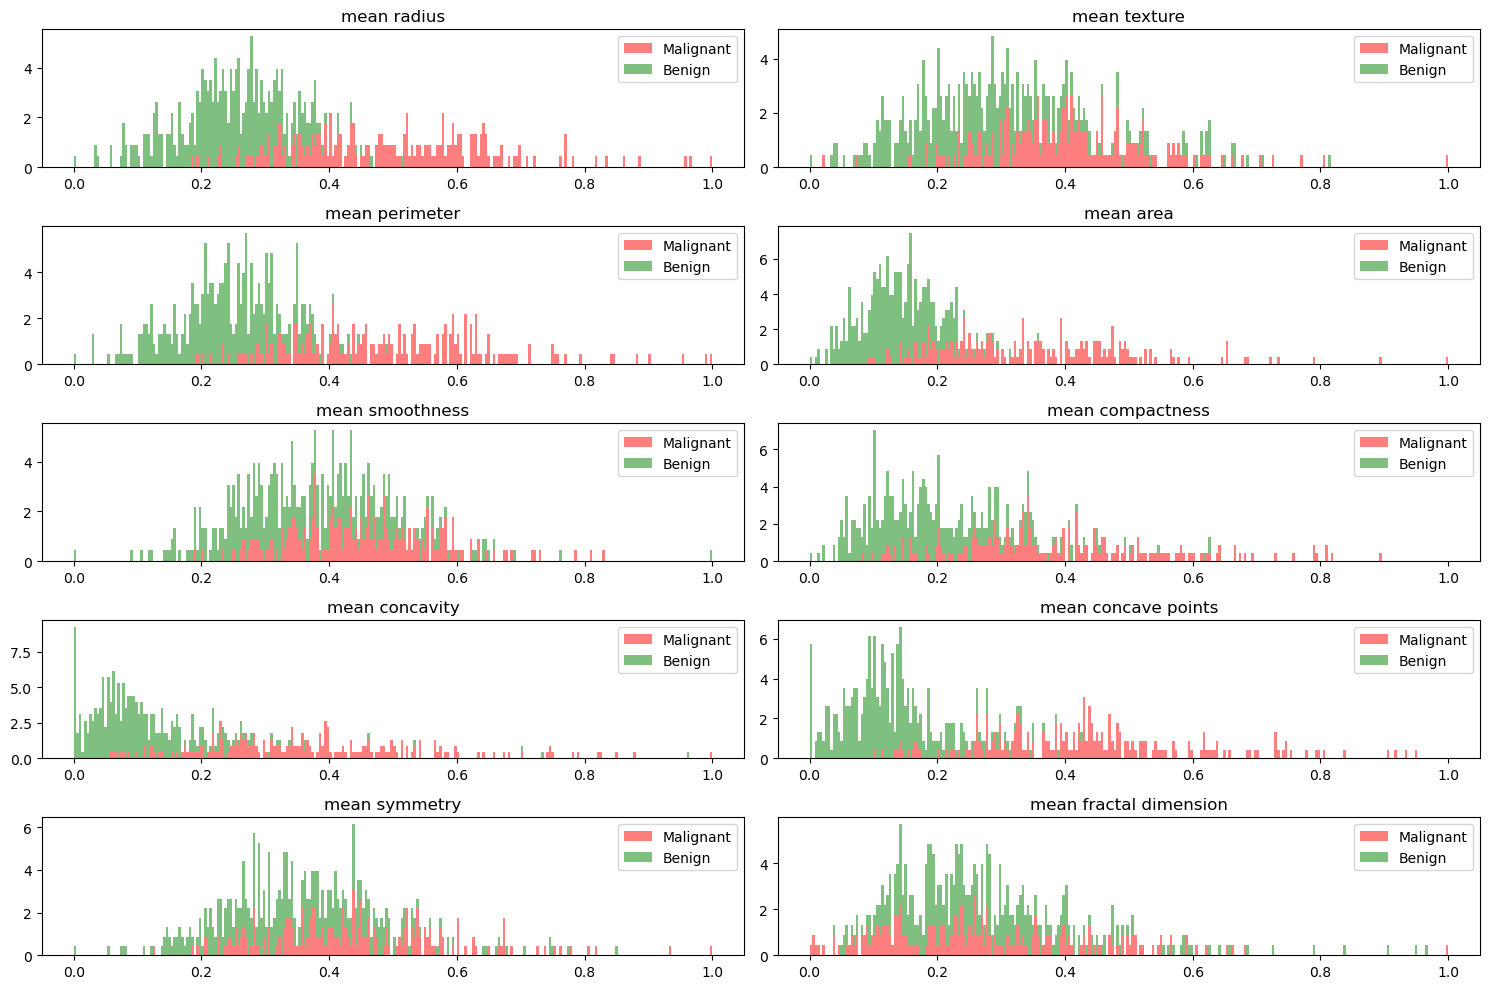

In [13]:
feature_names = breast_cancer_data.feature_names
feature_means = feature_names[:10]

# Correcting the number of rows in the subplots to match the first quarter of the features
fig, axes = plt.subplots(nrows=5, ncols=2, figsize = (15,10))
axes = axes.flatten()  # Flatten to ensure it's iterable

dataMalignant = df[df['class'] == 'malignant']
dataBenign = df[df['class'] == 'benign']

for idx, ax in enumerate(axes):
    feature = feature_means[idx]
    binwidth = (df[feature].max() - df[feature].min()) / 250
    # Create histograms
    ax.hist([dataMalignant[feature], dataBenign[feature]], 
            bins=np.arange(df[feature].min(), df[feature].max() + binwidth, binwidth), 
            alpha=0.5, stacked=True, density=True, label=['Malignant', 'Benign'], color=['r', 'g'])
    ax.legend(loc='upper right')
    ax.set_title(feature)

plt.tight_layout()
plt.savefig('mean_features_hist.png')
plt.show()

# Training a classical model

Training a machine learning model generally involves feeding the model a section of the data, inlcuding labels, this is called 'Supervised Learning'. This will allow the model to gain an understanding of what feature values line up with the classification or label values. In general, 80% of the data set will be used for training. The other 20% will be called the 'test set'. These will be from the same data set, but will have the target label removed. It is then up to the machine learning model to attempt to classify the new data. We will then check what the model predicted for the test data against what the correct labels are to quantify how good the model will be at classifying new data. 

## Support Vector Machine (SVM)

**Support Vector Machine (SVM)** is a supervised machine learning algorithm used for both classification and regression tasks. However, it is more commonly used in classification problems. 

### Key Features:

- **Classification Boundaries**: SVMs are best known for their ability to create non-linear boundaries with the help of kernel functions.

- **Margin Maximization**: The core idea of SVM is to identify the best decision boundary (hyperplane) that separates classes in the feature space. This boundary is chosen to be the one that has the maximum margin, i.e., the maximum distance between data points of both classes.

### Applications:

- SVMs are used in applications like face detection, handwriting recognition, image classification, and many areas of biology and physics.

### Advantages:

**Versatility**: Different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

### Disadvantages:

- **Sensitivity to Noisy Data**: SVMs are sensitive to the type of kernel used and can overfit if the data is very noisy.

In [14]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)

In [15]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [16]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.98
Classical SVC on the test dataset:     0.98


# Training a QML Model

We are training a 'Variational Quanum Classifier', or VQC. It takes a map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. 

In [18]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps = 1)
#feature_map.decompose().draw('mpl', fold=50)

## ZZFeatureMap
The ZZFeatureMap specifically involves the application of Z⊗Z interactions, where "Z" represents the Pauli-Z operator, applied to pairs of qubits. These interactions, combined with single-qubit rotations that encode the input data, create entangled quantum states that reflect the structure of the input data. The name ZZFeatureMap comes from the use of these ZZ interactions, which are key to the map's ability to capture and exploit correlations in the input data in a way that is uniquely quantum.

x\[0\] ,,, x\[3\] are placehoders for the features.

In [41]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)
#ansatz.decompose().draw('mpl', fold = 25)

The parameters x\[0\] to x\[15\] are the trainable weights of the classifier. 

In [20]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

Using a simulator to train: 

In [21]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [22]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

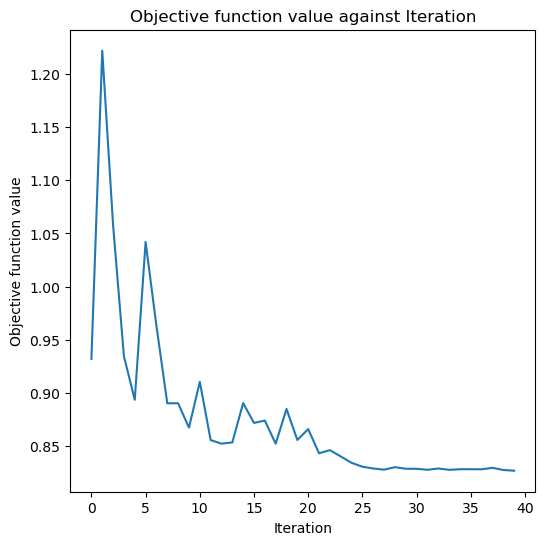

Training time: 29.831084966659546


In [28]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

# Clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [29]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.69
Quantum VQC on the test dataset:     0.61


# Feature Reduction

<AxesSubplot:>

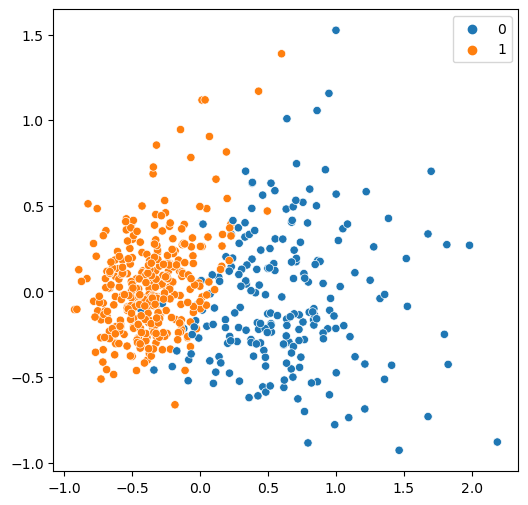

In [30]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [31]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}") 

Classical SVC on the training dataset: 0.95
Classical SVC on the test dataset:     0.95


In [32]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [33]:
optimizer = COBYLA(maxiter=40) # reduction of iterations due to fewer qubits

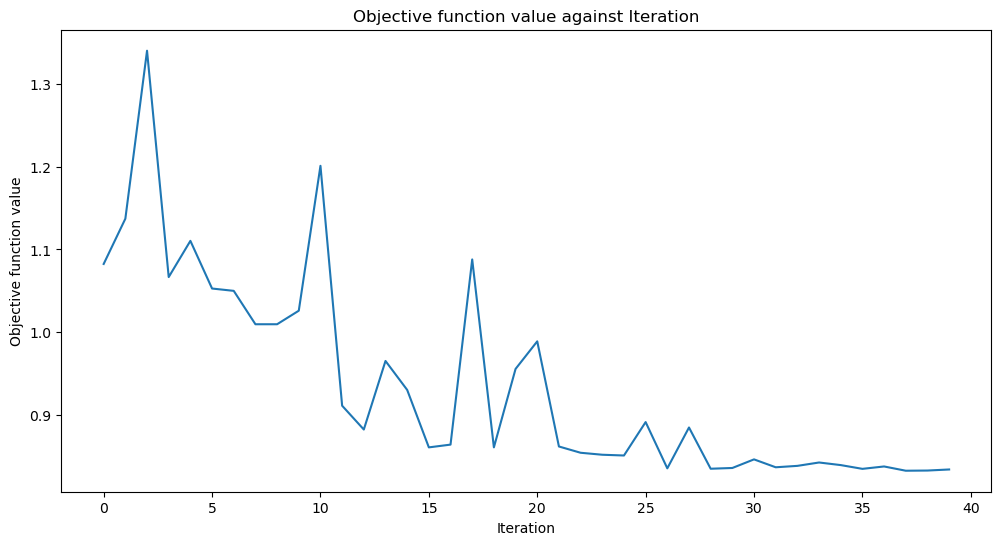

Training time: 30 seconds


In [34]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [35]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.68
Quantum VQC on the test dataset using RealAmplitudes:     0.63


Note the objective function is almost flattening, meaning increasing the number of iterations won't be able to increase the score. We will need to try another ansatz. 

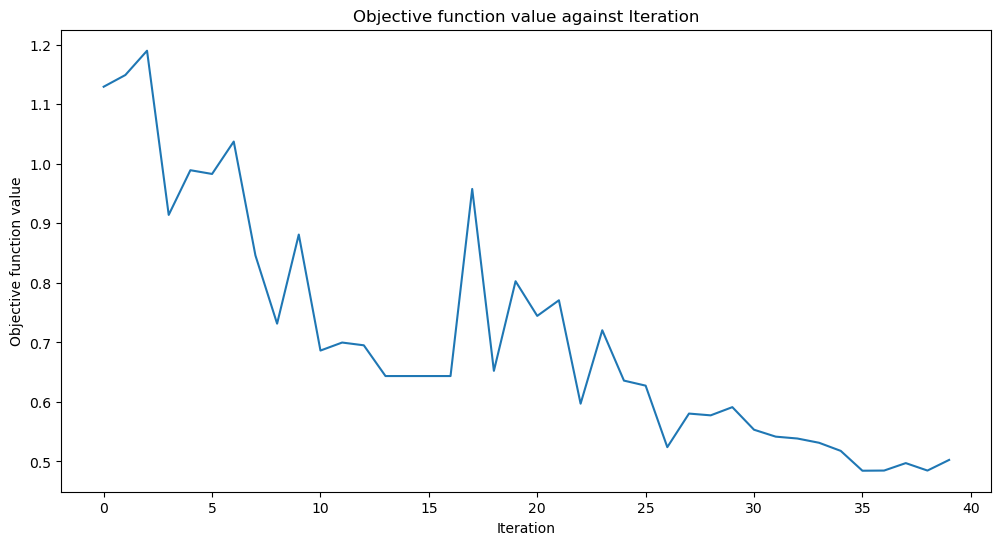

Training time: 41 seconds


In [36]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [37]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.87
Quantum VQC on the test dataset using EfficientSU2:     0.83


Better than previous. lets try increase the number of iterations. 

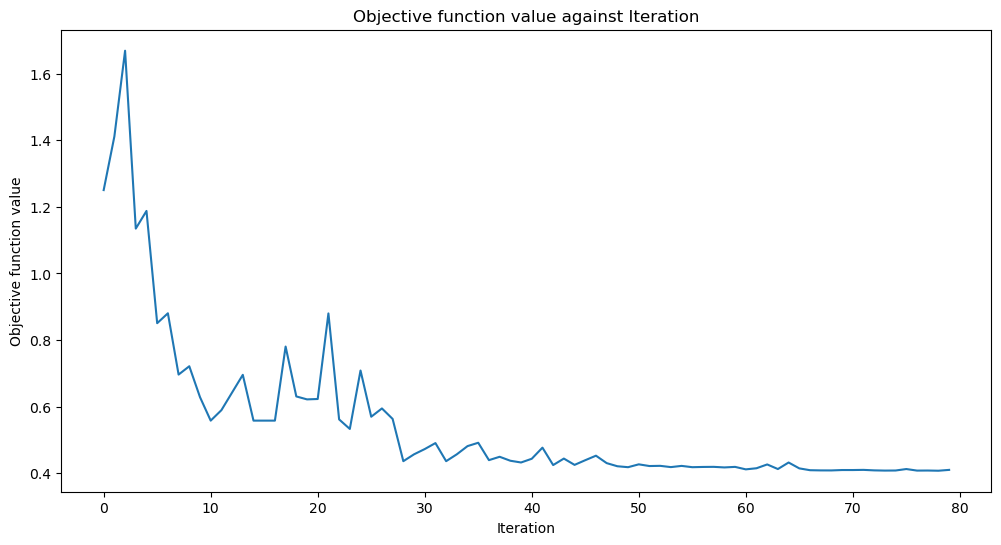

Training time: 87 seconds


In [38]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=80)

vqc2 = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc2.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [39]:
train_score_q3_eff = vqc2.score(train_features, train_labels)
test_score_q3_eff = vqc2.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q3_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q3_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.90
Quantum VQC on the test dataset using EfficientSU2:     0.86


In [40]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")
print(f"----------------------------------------------------------")
print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q3_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q3_eff:.2f}")   

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.98 |       0.98
VQC, 4 features, RealAmplitudes |       0.69 |       0.61
----------------------------------------------------------
SVC, 2 features                 |       0.95 |       0.95
VQC, 2 features, RealAmplitudes |       0.68 |       0.63
VQC, 2 features, EfficientSU2   |       0.87 |       0.83


In [1]:
def callback_graph(weights, obj_func_eval):
    global current_dataset
    clear_output(wait=True)
    objective_func_vals_dict[current_dataset].append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    for description, obj_vals in objective_func_vals_dict.items():
        if obj_vals:  # Plot only if there are values
            iterations = range(len(obj_vals))
            plt.plot(iterations, obj_vals, label=description)
            # Annotate the most recent point
            plt.annotate(f"{obj_vals[-1]:.2f}",
                         (iterations[-1], obj_vals[-1]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize=8)

    plt.legend()
    plt.show()


In [3]:
training_times = {}
vqc_scores = {}

objective_func_vals_dict = {
    "Full Features": [],
    "Missing Sepal Length": [],
    "Missing Sepal Width": [],
    "Missing Petal Length": [],
    "Missing Petal Width": []
}

for i, description in enumerate(data_descriptions):
    features = full_features 
    if i == 0:
        features = features # Run VQC on full feature set first
    else:
        features = np.delete(features, i-1, axis = 1)
    
    num_features = features.shape[1]  # Adjusted to current feature count
    current_dataset = description
    
    # Dynamically adjust the feature map and ansatz for the current number of features
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = EfficientSU2(num_qubits=num_features, reps=3)
    
    
    # Prepare features and labels
    features_scaled = MinMaxScaler().fit_transform(features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features_scaled, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    # Initialize VQC for the adjusted feature map and ansatz
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )
    # Measure training time
    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    
    # Scores
    train_score_quantum = vqc.score(train_features, train_labels)
    test_score_quantum = vqc.score(test_features, test_labels)
    vqc_scores[description] = {'Training Score': train_score_quantum, 'Test Score': test_score_quantum}

    # Store elapsed time for training
    training_times[description] = elapsed_time
    print(f"Training time: {elapsed_time:.2f} seconds")

NameError: name 'plt' is not defined

Resources: 

- [IBM](https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html) 
- [QML Summer School 2021](https://youtube.com/playlist?list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&si=zTRQ8YI7knonf7Nw)
- [datacamp](https://www.datacamp.com/tutorial/introduction-t-sne)
- [kaggle](https://www.kaggle.com/code/djokester/visualising-the-breast-cancer-wisconsin-data-set)